 # Importa bibliotecas

In [1]:
import pandas as pd
import glob
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Masking, Dropout
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import KFold
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import datetime
import pickle
import os
import random
import tensorflow as tf


2025-09-15 13:49:14.171079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757954954.252251   32698 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757954954.273744   32698 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757954954.444999   32698 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757954954.445024   32698 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757954954.445026   32698 computation_placer.cc:177] computation placer alr

 ## Definições

In [2]:
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


 # Funções

In [3]:
def save_history(history, timestamp):
    with open(f'training_history/pkl/{timestamp}.pkl', 'wb') as f:
        pickle.dump(history.history, f)


 # Preparando dados

In [4]:
csv_files = glob.glob('/mnt/d/dados_surdos/CSVs/*.csv')

dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df


,landmark_0_x,landmark_0_y,landmark_0_z,landmark_1_x,landmark_1_y,landmark_1_z,landmark_2_x,landmark_2_y,landmark_2_z,landmark_3_x,...,landmark_18_z,landmark_19_x,landmark_19_y,landmark_19_z,landmark_20_x,landmark_20_y,landmark_20_z,repetition,frame,word
0,-0.018503,0.082473,0.012359,-0.038244,0.052717,-0.003482,-0.041650,0.019357,-0.003818,-0.044734,...,-0.030975,0.015069,0.032954,-0.044006,0.005922,0.042659,-0.027308,0,0.0,amanda
1,-0.019564,0.082302,-0.005283,-0.038287,0.049727,-0.015436,-0.043065,0.016212,-0.010967,-0.043814,...,-0.033387,0.015812,0.032467,-0.046086,0.006886,0.043515,-0.030460,0,1.0,amanda
2,-0.019889,0.083195,0.001091,-0.038524,0.050895,-0.010739,-0.043251,0.017482,-0.007753,-0.044321,...,-0.034229,0.014959,0.033327,-0.046357,0.005194,0.043947,-0.030197,0,2.0,amanda
3,-0.019555,0.083148,-0.000637,-0.038343,0.050427,-0.011885,-0.043177,0.017241,-0.008733,-0.044665,...,-0.034493,0.014198,0.033871,-0.046757,0.004756,0.044371,-0.030852,0,3.0,amanda
4,-0.019964,0.082738,-0.000807,-0.038683,0.050372,-0.012193,-0.043376,0.016974,-0.008550,-0.044471,...,-0.034294,0.014338,0.033735,-0.046465,0.005141,0.044447,-0.030369,0,4.0,amanda
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192686,-0.027502,0.075608,0.048387,0.006603,0.055570,0.041092,0.032652,0.040261,0.029332,0.047944,...,-0.030340,0.003296,0.041873,-0.022294,0.000718,0.052953,-0.006372,9,371.0,zimbabwe
192687,-0.021065,0.073777,0.051802,0.010279,0.051962,0.042363,0.035151,0.036618,0.030891,0.050052,...,-0.028829,0.006924,0.043964,-0.022340,0.005159,0.054856,-0.006336,9,372.0,zimbabwe
192688,-0.018004,0.064724,0.063438,0.010495,0.046793,0.048580,0.034258,0.033162,0.036475,0.048513,...,-0.023351,0.001211,0.047076,-0.015310,-0.000027,0.058120,0.000113,9,373.0,zimbabwe
192689,-0.017803,0.046932,0.077965,0.011545,0.036904,0.052112,0.033960,0.026817,0.038158,0.048779,...,-0.015206,-0.005043,0.039852,-0.010253,-0.002557,0.052289,0.002224,9,374.0,zimbabwe


In [5]:
# Normaliza features com valores entre 0 e 1
scaler = MinMaxScaler()
landmark_cols = list(df.columns[:63])
df[landmark_cols] = scaler.fit_transform(df[landmark_cols])


In [6]:
# Separa features e labels por vídeo
grouped = df.groupby(['word', 'repetition'])
X_raw = []
y_raw = []

for (word, rep), group in grouped:
    sequence = group[landmark_cols].values
    X_raw.append(sequence)
    y_raw.append(word)


 # KFold Cross Validation

In [7]:
max_len = max(len(seq) for seq in X_raw)
N_SPLITS = 3

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
all_fold_accuracies = []
all_fold_losses = []
histories = []

for fold, (train_index, val_index) in enumerate(kf.split(X_raw), 1):
    print(f"\n========== FOLD {fold} ==========")

    X_train_raw = [X_raw[i] for i in train_index]
    y_train_raw = [y_raw[i] for i in train_index]
    X_val_raw   = [X_raw[i] for i in val_index]
    y_val_raw   = [y_raw[i] for i in val_index]

    X_train = pad_sequences(X_train_raw, maxlen=max_len, padding='post', dtype='float32')
    X_val   = pad_sequences(X_val_raw,   maxlen=max_len, padding='post', dtype='float32')

    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train_raw)
    y_val = label_encoder.transform(y_val_raw)

    num_classes = len(label_encoder.classes_)

    model = Sequential()
    model.add(Masking(mask_value=0.0, input_shape=(max_len, 63)))
    model.add(LSTM(16))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    checkpoint_filepath = f'models/fold_{fold}_checkpoint.model.keras'

    early_stop = EarlyStopping(patience=30, restore_best_weights=True)
    csv_logger = CSVLogger(f'training_log_fold_{fold}.csv')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, min_lr=0.00001, verbose=1)
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )

    history = model.fit(
        X_train, y_train,
        batch_size=16,
        epochs=10,
        verbose=1,
        validation_data=(X_val, y_val),
        shuffle=True,
        callbacks=[csv_logger, reduce_lr, model_checkpoint_callback]
    )

    histories.append(history)

    best_model = load_model(checkpoint_filepath)
    val_loss, val_accuracy = best_model.evaluate(X_val, y_val, verbose=0)
    print(f"FOLD {fold} - Accuracy: {val_accuracy:.4f}, Loss: {val_loss:.4f}")

    all_fold_accuracies.append(val_accuracy)
    all_fold_losses.append(val_loss)



========== FOLD 1 ==========


/home/victor/.local/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-09-15 13:49:25.842797: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10


2025-09-15 13:49:26.127106: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.0422 - loss: 3.3054

2025-09-15 13:49:31.779397: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 425ms/step - accuracy: 0.0425 - loss: 3.3051 - val_accuracy: 0.0345 - val_loss: 3.2798 - learning_rate: 0.0010
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 433ms/step - accuracy: 0.0175 - loss: 3.2780 - val_accuracy: 0.0345 - val_loss: 3.2683 - learning_rate: 0.0010
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 412ms/step - accuracy: 0.0376 - loss: 3.2610 - val_accuracy: 0.0345 - val_loss: 3.2722 - learning_rate: 0.0010
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 376ms/step - accuracy: 0.0449 - loss: 3.2524 - val_accuracy: 0.0115 - val_loss: 3.2784 - learning_rate: 0.0010
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 389ms/step - accuracy: 0.0769 - loss: 3.2322 - val_accuracy: 0.0230 - val_loss: 3.2785 - learning_rate: 0.0010
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 391ms/step - accuracy: 0.0106 - loss: 3.2447 - val_accuracy: 0.0115 - val_loss: 3.2780 - learning_rate: 0.0010
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 382ms/step - accuracy: 0.0320 - loss: 3.2557 - val_accurac

2025-09-15 13:50:11.166396: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


FOLD 1 - Accuracy: 0.0345, Loss: 3.2798

========== FOLD 2 ==========
Epoch 1/10


/home/victor/.local/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.0129 - loss: 3.3659

2025-09-15 13:50:17.258749: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 431ms/step - accuracy: 0.0143 - loss: 3.3614 - val_accuracy: 0.0115 - val_loss: 3.2829 - learning_rate: 0.0010
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 408ms/step - accuracy: 0.0302 - loss: 3.2781 - val_accuracy: 0.0230 - val_loss: 3.2941 - learning_rate: 0.0010
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 408ms/step - accuracy: 0.0994 - loss: 3.2451 - val_accuracy: 0.0575 - val_loss: 3.3035 - learning_rate: 0.0010
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 395ms/step - accuracy: 0.0340 - loss: 3.2509 - val_accuracy: 0.0345 - val_loss: 3.3063 - learning_rate: 0.0010
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 391ms/step - accuracy: 0.0885 - loss: 3.2254 - val_accuracy: 0.0690 - val_loss: 3.3122 - learning_rate: 0.0010
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step - accuracy: 0.0684 - loss: 3.2252 - val_accuracy: 0.0345 - val_loss: 3.3090 - learning_rate: 0.0010
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 388ms/step - accuracy: 0.0807 - loss: 3.2337 - val_accurac

2025-09-15 13:50:56.998645: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


FOLD 2 - Accuracy: 0.0805, Loss: 3.2599

========== FOLD 3 ==========
Epoch 1/10


/home/victor/.local/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.0519 - loss: 3.3590

2025-09-15 13:51:02.992245: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 419ms/step - accuracy: 0.0509 - loss: 3.3559 - val_accuracy: 0.0349 - val_loss: 3.2713 - learning_rate: 0.0010
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 388ms/step - accuracy: 0.0583 - loss: 3.2755 - val_accuracy: 0.0233 - val_loss: 3.2732 - learning_rate: 0.0010
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 373ms/step - accuracy: 0.0409 - loss: 3.2741 - val_accuracy: 0.0233 - val_loss: 3.2770 - learning_rate: 0.0010
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step - accuracy: 0.0616 - loss: 3.2632 - val_accuracy: 0.0349 - val_loss: 3.2860 - learning_rate: 0.0010
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 395ms/step - accuracy: 0.0198 - loss: 3.2697 - val_accuracy: 0.0465 - val_loss: 3.2873 - learning_rate: 0.0010
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 391ms/step - accuracy: 0.0489 - loss: 3.2553 - val_accuracy: 0.0581 - val_loss: 3.2875 - learning_rate: 0.0010
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 388ms/step - accuracy: 0.0469 - loss: 3.2527 - val_accurac

2025-09-15 13:51:41.935619: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


FOLD 3 - Accuracy: 0.0581, Loss: 3.2875


In [8]:
resultados = []
resultados.append("\n========== RESULTADOS FINAIS ==========")
for i, (acc, loss) in enumerate(zip(all_fold_accuracies, all_fold_losses), 1):
    resultados.append(f"Fold {i}: Accuracy = {acc:.4f}, Loss = {loss:.4f}")
media = f"Média de acurácia: {np.mean(all_fold_accuracies):.4f}"
resultados.append(media)

# printa no terminal
for linha in resultados:
    print(linha)

# escreve no arquivo
with open('results.txt', 'w') as f:
    for linha in resultados:
        print(linha, file=f)



========== RESULTADOS FINAIS ==========
Fold 1: Accuracy = 0.0345, Loss = 3.2798
Fold 2: Accuracy = 0.0805, Loss = 3.2599
Fold 3: Accuracy = 0.0581, Loss = 3.2875
Média de acurácia: 0.0577


 # Gráficos de Acurácia e Loss por Fold

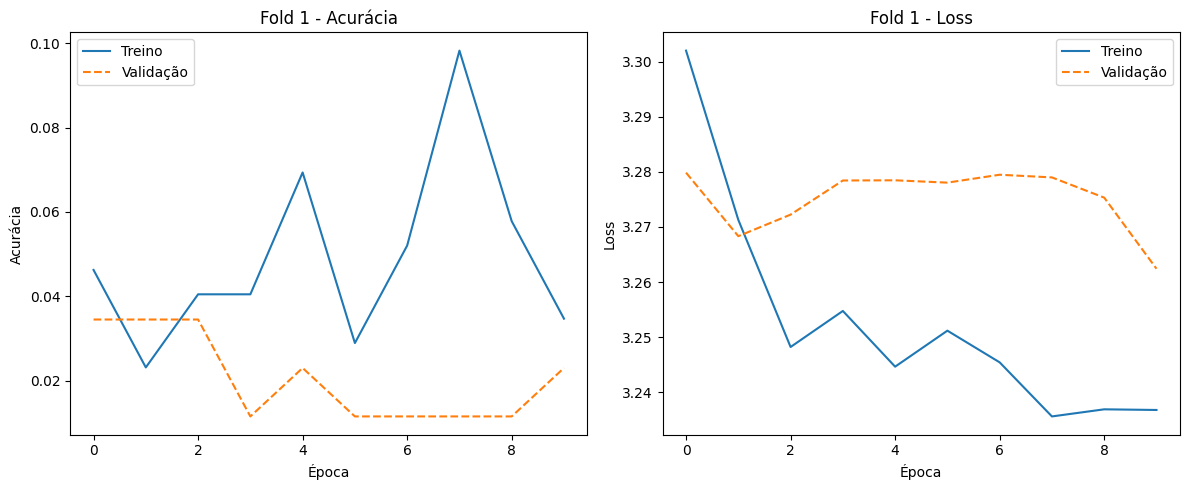

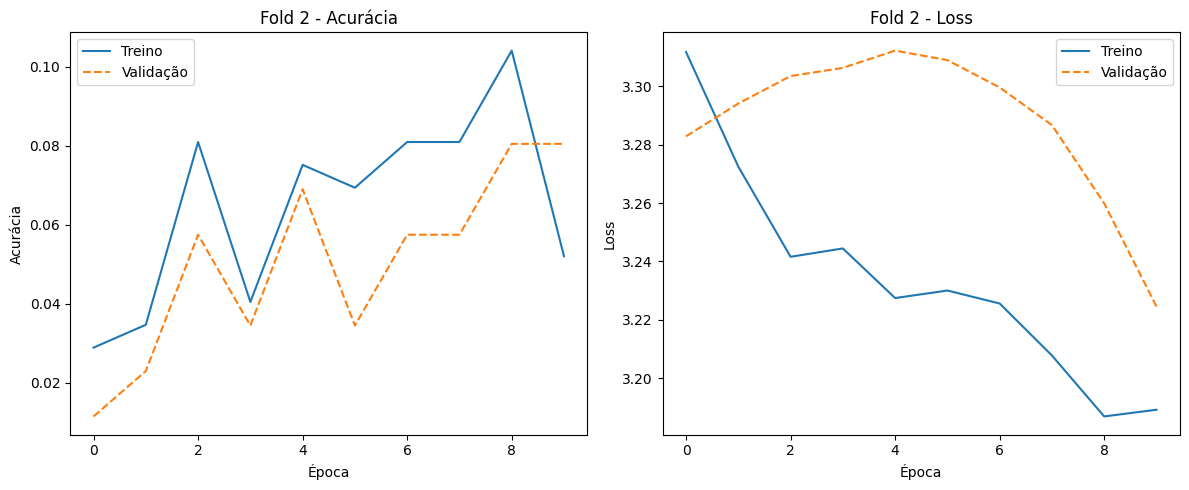

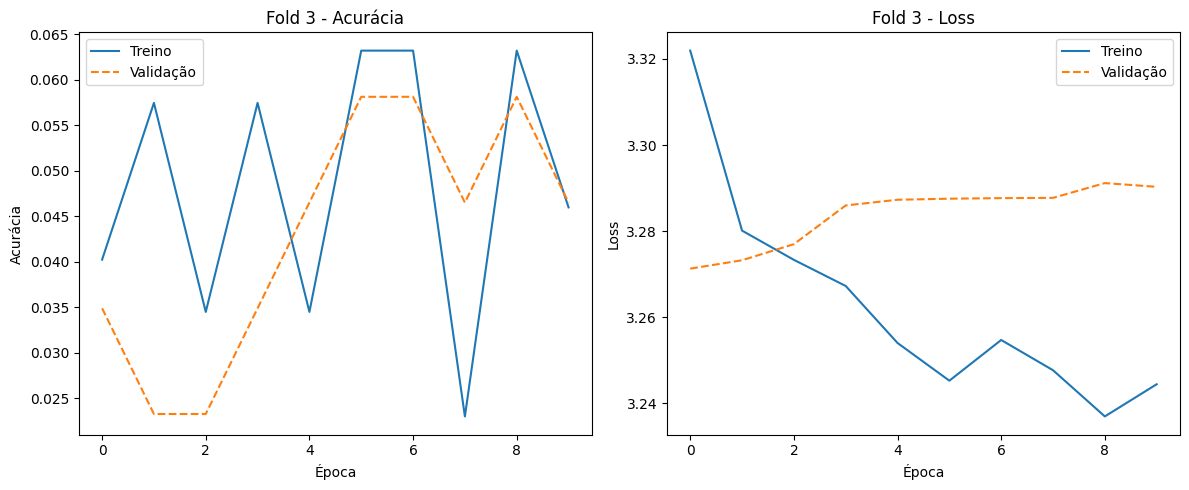

In [9]:
for i, history in enumerate(histories, 1):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Treino')
    plt.plot(history.history['val_accuracy'], linestyle='--', label='Validação')
    plt.title(f'Fold {i} - Acurácia')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Treino')
    plt.plot(history.history['val_loss'], linestyle='--', label='Validação')
    plt.title(f'Fold {i} - Loss')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()

    fig_file_path = f"training_history/img/{timestamp}.png"
    #plt.savefig(fig_file_path) # se quiser salvar a imagem, descomentar a linha

    plt.show()

